# Visual Testing Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [1]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Mounted at /content/gdrive
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


### Imports

In [2]:
!pip install wntr
%matplotlib inline
import wntr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

     |████████████████████████████████| 4.2 MB 4.2 MB/s 


In [3]:
import utils
from utils.Network import WDN
from utils.Dataloader import Dataloader

# Attention: Run twice for real reload effect
import importlib
importlib.reload(utils.Network)
importlib.reload(utils.Dataloader)

<module 'utils.Dataloader' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/utils/Dataloader.py'>

## Main

### New Network

In [4]:
def plot(df, xlabel="Time (h)", ylabel="Pressure (m)", location="upper right", line_at=[], highlight_first=False):
  plt.figure()
  ax = df.plot()
  if highlight_first:
    plt.setp(ax.lines[0], linewidth=3)
  text = ax.set_xlabel(xlabel)
  text = ax.set_ylabel(ylabel)
  for line in line_at:
    plt.axvline(x=line, color='k', linestyle='--')
  plt.legend(loc = location)
  plt.show()

Neues Netz anlegen und anzeigen.

Nodes: ['10', '11', '12', '13', '2', '21', '22', '23', '31', '32', '9']
->Important: ['11', '12', '13', '21', '22', '23', '31', '32']
Edges: [('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


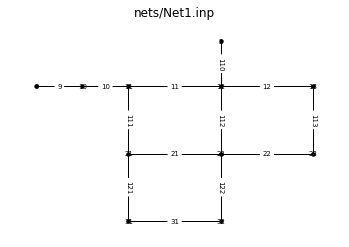

In [5]:
wdn = WDN("nets/Net1.inp", ['11','12','13','21','22','23','31','32'])
wdn.show()

Simulieren des Idealzustandes über ein Jahr.

In [20]:
p = wdn.simulate(12*30*24)
data = Dataloader(p, wdn.important_nodes)

### Druck ohne Lecks

Auszug (erste vier Tage) aus den Druck-Ergebnissen.
Man sieht klar die Tages-spezifischen Schwankungen.

<Figure size 432x288 with 0 Axes>

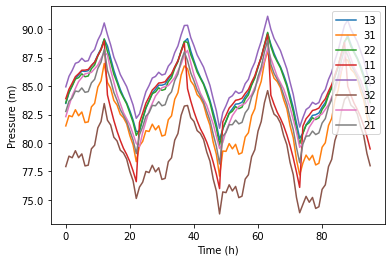

In [7]:
plot(data.get_nodes()[:4*24])

Über das Jahr verteilte Messwerte pro Sensor.
Auffälig: Nach einer kurzen "Eingewöhnungsphase" bleiben die Werte stabil und sind keinen Jahreszeiten-bedingten Schwankungen ausgesetzt.

<Figure size 432x288 with 0 Axes>

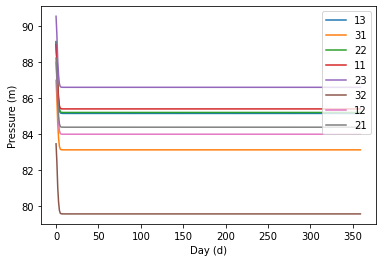

In [8]:
plot(data.get_days_at_hour(12), xlabel="Day (d)")

Auch zu verschiedenen Zeitpunkten gibt es keine Jahreszeiten-besierten Schwankungen.

<Figure size 432x288 with 0 Axes>

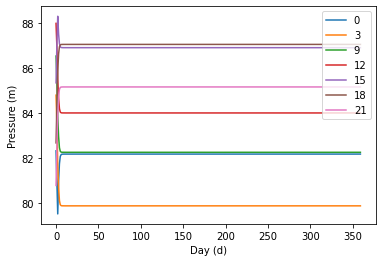

In [9]:
plot(data.get_days_at_hours('12', hours=[0, 3, 9, 12, 15, 18, 21]), xlabel="Day (d)")

<Figure size 432x288 with 0 Axes>

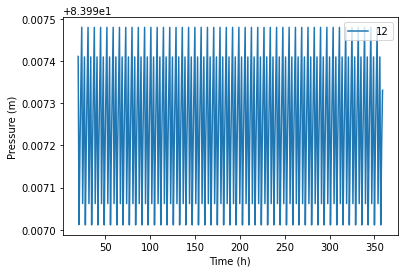

In [24]:
plot(data.get_days_at_hour(12)[['12']].iloc[20:])

In [37]:
data.get_days_at_hour(12)[['12']].iloc[50:].iloc[::7, :]

,12
day,
50,83.997197
57,83.997197
64,83.997197
71,83.997197
78,83.997197
85,83.997197
92,83.997197
99,83.997197
106,83.997197


### Druck mit Leck

Simulation bei einem Leck an Tag 10 bei einer Laufzeit von einem Jahr.

In [10]:
p_leak = wdn.simulate(12*30*24, [('11', 0.05, 10*24+3, 10*24+21)])
data_leak = Dataloader(p_leak, wdn.important_nodes)

/usr/local/lib/python3.7/dist-packages/wntr/sim/hydraulics.py:272: UserWarning: Pump 9 has exceeded its maximum flow.
  warnings.warn('Pump ' + name + ' has exceeded its maximum flow.')


Auszug zeigt den Druckverlust.

<Figure size 432x288 with 0 Axes>

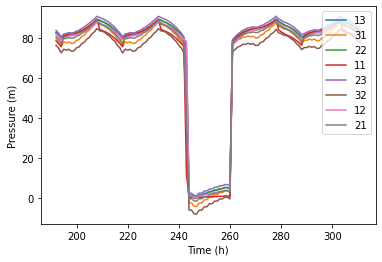

In [11]:
plot(data_leak.get_nodes()[8*24:13*24])

Im Jahresvergleich (hier nur erster Monat) sieht man wieder die "Ëingewöhnungsphase" nach einem Leck.

<Figure size 432x288 with 0 Axes>

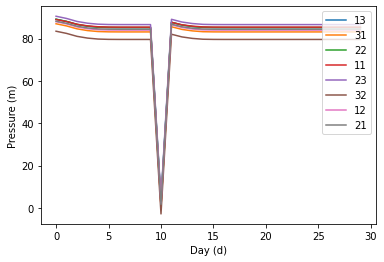

In [12]:
plot(data_leak.get_days_at_hour(12)[:30], xlabel="Day (d)")

<Figure size 432x288 with 0 Axes>

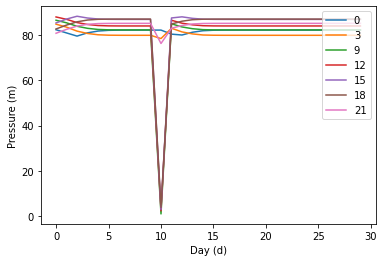

In [13]:
plot(data_leak.get_days_at_hours('12', hours=[0, 3, 9, 12, 15, 18, 21])[:30], xlabel="Day (d)")

### Verschiedene Leck-Stärken

In [14]:
p_no_leak = wdn.simulate(30*24)
data_no_leak = Dataloader(p_no_leak, wdn.important_nodes)

/usr/local/lib/python3.7/dist-packages/wntr/sim/hydraulics.py:272: UserWarning: Pump 9 has exceeded its maximum flow.
  warnings.warn('Pump ' + name + ' has exceeded its maximum flow.')


<Figure size 432x288 with 0 Axes>

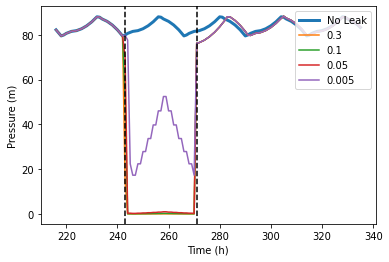

In [15]:
df = data_no_leak.get_nodes(['12'])
df.rename(columns={'12':'No Leak'}, inplace=True)
for strength in [0.3, 0.1, 0.05, 0.005]:
  p = wdn.simulate(30*24, [('12', strength, 10*24+3, 11*24+7)])
  data = Dataloader(p, wdn.important_nodes)
  df[strength] = data.get_nodes(['12'])['12'].values.tolist()

plot(df[9*24:14*24], line_at=[10*24+3, 11*24+7], highlight_first=True)

<Figure size 432x288 with 0 Axes>

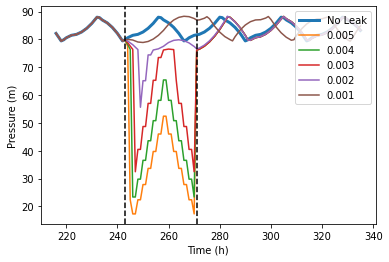

In [16]:
df = data_no_leak.get_nodes(['12'])
df.rename(columns={'12':'No Leak'}, inplace=True)
for strength in [0.005, 0.004, 0.003, 0.002, 0.001]:
  p = wdn.simulate(30*24, [('12', strength, 10*24+3, 11*24+7)])
  data = Dataloader(p, wdn.important_nodes)
  df[strength] = data.get_nodes(['12'])['12'].values.tolist()

plot(df[9*24:14*24], line_at=[10*24+3, 11*24+7], highlight_first=True)

<Figure size 432x288 with 0 Axes>

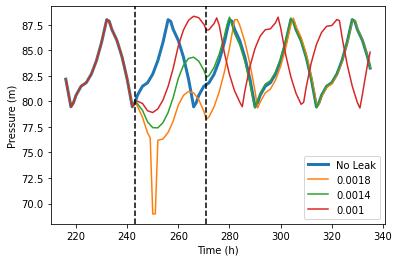

In [17]:
df = data_no_leak.get_nodes(['12'])
df.rename(columns={'12':'No Leak'}, inplace=True)
for strength in [0.0018, 0.0014, 0.001]:
  p = wdn.simulate(30*24, [('12', strength, 10*24+3, 11*24+7)])
  data = Dataloader(p, wdn.important_nodes)
  df[strength] = data.get_nodes(['12'])['12'].values.tolist()

plot(df[9*24:14*24], location="lower right", line_at=[10*24+3, 11*24+7], highlight_first=True)

<Figure size 432x288 with 0 Axes>

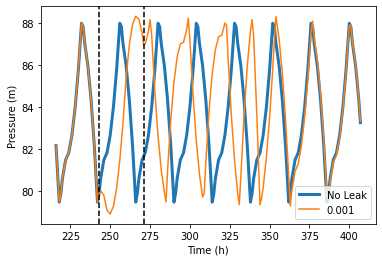

In [18]:
df = data_no_leak.get_nodes(['12'])
df.rename(columns={'12':'No Leak'}, inplace=True)
for strength in [0.001]:
  p = wdn.simulate(30*24, [('12', strength, 10*24+3, 11*24+7)])
  data = Dataloader(p, wdn.important_nodes)
  df[strength] = data.get_nodes(['12'])['12'].values.tolist()

plot(df[9*24:17*24], location="lower right", line_at=[10*24+3, 11*24+7], highlight_first=True)

<Figure size 432x288 with 0 Axes>

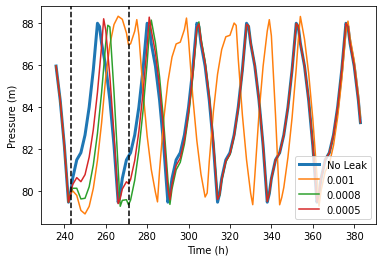

In [19]:
df = data_no_leak.get_nodes(['12'])
df.rename(columns={'12':'No Leak'}, inplace=True)
for strength in [0.001, 0.0008, 0.0005]:
  p = wdn.simulate(30*24, [('12', strength, 10*24+3, 11*24+7)])
  data = Dataloader(p, wdn.important_nodes)
  df[strength] = data.get_nodes(['12'])['12'].values.tolist()

plot(df[9*24+20:16*24], location="lower right", line_at=[10*24+3, 11*24+7], highlight_first=True)